## NLP Class Final Project Read Data

In [92]:
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm

import re
import nltk
import os
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 600)

#insights jobs and tasks will have major impact by AI
#provide recommendations on how it can be useful to automate tasks / jobs to improve employee productivity
#keywords: ChatGPT / ConversationalAI - look for them like this
#find topics - begin with - done with the cleaning - which news articles are talking about the important topics?
#disregard those news articles that are not relevant
#see which are the emerging technologies in this data through topic modeling
#sample data based on relevance of data
#search on website - find the keywords readily on a website (emerging technologies)
#talk about trends - date - how these keywords are performing over time (ChatGPT)
#ppt
#exec summary - cant tell what i have done - show what you found
#each topic
#sentimental analysis
#2 ways
#create own corpus
#or use pre-existing ones - 
#targeted sentiment to words like AI / entities
#200k news articles 
#run sentiment modeling (naive bayes) - find entities - get keyword extraction from the entities (through topic modeling)
#first ran LDA and then ran BERT on the overall
#what can you really tell from articles? Which tasks can be automated? 
#do you actually see emerging technology that will be able to automate task related to visual cortex?
#LLms are good at text summarization / extraction / text generation
#LLM cannot effectively drive a lawn
#what can you find in these artiles - is it really legal / office can effectively be automated? or in construction sector impossible to be automated?
#amazon / alibaba really good at package picking jobs in warehouses
#those machines are actually working - are we going to expect a similar breakthrough for physical moving devices in NLP space with generative AI?
#do you see specific trends in articles that will lead you to believe from Goldman Sachs are correct or incorrect based on how technologies develop?
#objective: identify which types of tasks and jobs are going to see biggest impact from AI
# executive summary - tell you what you found
# clean-up - article randoms - filtering (out of 200k - taking the articles away)
# sentiment analysis - explicity customized - if you open a text blob - apply it to technology articles - you will not get good sentiment - train your own model and find a model that was pretrained on a similar corpus
# sentiment over time - did it change or is it consistent? 16 / 17 months? sentiment might also change drastically
# entitiy organizations / people identification - in articles - why? find people say work at meta is going to be transformed
# targeted sentiment - if you finding the technology that says our RPA - dont tell sentiment of entire article but find sentiment with regard to RPA  
#not what you believe but what you find from text
#are we going to see a similar breakthrough
#ran topic 
#eliminate new lines / tabs / randoms of the web crawls - take out irrelevant text (use regex to take out) - make sure noise to text ratio is reasonable
#take out irrelevant articles
#what drove that successful ai initiatives? maturity of tech? was enough money poured? why certain industries are being transformed or not transformed? 
#what is constantly positioned as a failure
#failure - failure and then all of a sudden - it is a success - no one thought AI solutoin can code nearly as good as it can today
#think about how these new technologies emerging - LLMs came only after nov
#see any named entities mentioned? companies? gov institutions? government institutions - what can they do in creating policies? china - US - india? 
#sentiment - identify entities and then apply targeted sentiment!  what companies should invest into data science based on success stories? if you are healthcare / construction / police union - should you invest into it? electrician union? 
#what types of applications cannot be transformed based on today's technologies? failure - certain industries in common? projects in common?


#
#lora_config = LoraConfig(
 #r=16, #lora_2 = 4 in vishals #4 attention heads - 
 #lora_alpha=32, #16 in vishals
 #target_modules=["q", "v"],
 #lora_dropout=0.05,
 #bias="none",
 #task_type=TaskType.SEQ_2_SEQ_LM
)

#add_eos_token - sequence number at the end (for the end of the sequence)
#peft - library in hugging face
#




In [69]:
#!pip install pyarrow

In [3]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: total: 37.3 s
Wall time: 2min 27s


(200332, 5)

In [5]:
#save this dataframe so i do not have to keep reading it in
df_news_final_project.to_parquet('news_final_project.parquet', engine='pyarrow')
#where does it save?
!ls


ArrowMemoryError: realloc of size 2105540608 failed

In [70]:
import pandarallel
from pandarallel import pandarallel

In [71]:
import multiprocessing

num_processors = multiprocessing.cpu_count()

# Now you can use num_processors in your code.


In [72]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [6]:
# expand length of column width
pd.set_option('display.max_colwidth', 1000)

In [17]:
df_news_final_project.head()

,url,date,language,title,text
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, March 18, 2021\nPhoto taken on July 1, 2019, shows a sign for electronic toll collection (ETC) newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. (People’s Daily Online/Li Wenming)\n\n\tThanks to the application of an artificial intelligence (AI)-empowered roadside electronic toll collection (ETC) system, China’s capital city Beijing has seen significant im..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in corporate paid leave policies\n\nNews Parliament\n\nGet the Real Story\n\n \nNews\nTechnology\nServices\nHealthcare\nWorld\nBusiness\nEntertainment\n \n\nWorld \n\n\n \t\t\tChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot \t\t\n\n\n February 27, 2020February 27, 2020\nadmin\t\t\t\t\t\n\n\n 0 Comments\n\n\n Author Recent Posts admin Latest posts by admin (see all) Mansplaining in conferences: How can we get him to forestall? - February 27, 20..."
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interconnection\n▸ Manufacturing / Production Technology, Hardware & Services\n▸ News\n▸ Opto-Electronics\n▸ Passive Components\n▸ Power Electronics / Power Management\n▸ Programmable Logic\n▸ Smart Home Automation\n▸ Switches, Relays & Keypads\n▸ Telecoms, Datacoms, Wireless, IoT\n▸ Test & Measurement\n \n\nCategories\n\nEditor's Choice\n\n\nMultimedia, Videos\n\n\nAnalogue, Mixed Signal, LSI\n\n\nCircuit & System Protection\n\n\nComputer/Embedded Technology\n\n\nDesign Automation\n\n\nDSP, Micros & ..."
3,http://www.homeoffice.consumerelectronicsnet.com/strategy-analytics-71-of-smartphones-sold-globally-in-2021-will-be-ai-powered/,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net,"\n\nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net\n 

In [145]:
# value counts of language
df_news_final_project['language'].value_counts()

language
en    200332
Name: count, dtype: int64

In [ ]:
# around 60k news articles with the same titles
#around 1500 news articles with the same text - removed this 


In [147]:
df_news_final_project_1 = df_news_final_project.drop_duplicates(subset=['text'])
df_news_final_project_1.shape

(198564, 5)

In [8]:
# take a sample of 1000 rows
df_news_final_project_sample = df_news_final_project.sample(n=1000, random_state=1)

In [9]:
# reset index
df_news_final_project_sample.reset_index(drop=True, inplace=True)


In [14]:
import os
#save this dataframe so i do not have to keep reading it in
df_news_final_project_sample.to_parquet('news_final_project_sample.parquet', engine='pyarrow')
#where does it save?
cwd = os.getcwd()

In [15]:
cwd

'c:\\Users\\sanch\\MScA\\NLP'

In [18]:
# Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

import re
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['text'].str.replace('\n', ' ') 
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('\t', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('\r', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('<!--.*?-->', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('<script.*?>.*?</script>', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('<.*?>', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('http\S+|www.\S+', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('[^a-zA-Z0-9\s]', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('\s+', ' ')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].str.replace('^\s+|\s+$', ' ')



In [77]:
import nltk
import string
stopwords = set(nltk.corpus.stopwords.words('english'))

df_news_final_project_sample['clean_title'] = df_news_final_project_sample['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df_news_final_project_sample['clean_title'] = df_news_final_project_sample['clean_title'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [93]:
import nltk
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))  # define stopwords

def clean(string):
    
    url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
    mention_pattern = r'[\s]*@[\w]+'
    hashtag_pattern = r'[\s]*#[\w]+'
    copyright_pattern = r"©.*"
    string_fixed = re.sub(url_pattern, "", string)
    string_fixed = re.sub(hashtag_pattern, "", string_fixed)
    string_fixed = re.sub(mention_pattern, "", string_fixed)
    string_fixed = re.sub(copyright_pattern, "", string_fixed)  # Remove everything after "©"
    string_fixed = string_fixed.replace('\n', ' ')
    
    # Convert to lower case and remove stop words without tokenization
    words = string_fixed.split()  # split string into words
    words = [word.lower() for word in words if word.lower() not in stopwords and word.isalpha()]
    
    return " ".join(words)

# Applying the function to the dataframe
df_news_final_project_sample['cleaned_text'] = df_news_final_project_sample['content_clean'].apply(clean)


In [152]:
df_news_final_project_sample.shape

(1000, 10)

In [153]:
#filter dataframe 
ai_terms = '|'.join(["Artificial Intelligence", "Machine Learning", "Deep Learning", "Neural Network", "Natural Language Processing", "Supervised Learning", "Unsupervised Learning", "Reinforcement Learning", "Generative Adversarial Networks", "Convolutional Neural Networks", "Recurrent Neural Networks", "Transfer Learning", "Data Mining", "Big Data", "Algorithm", "Feature Extraction", "Feature Selection", "Overfitting", "Underfitting", "Bias-Variance Tradeoff", "Training Data", "Testing Data", "Validation Data", "Precision", "Recall", "F1 Score", "Gradient Descent", "Backpropagation", "Hyperparameters", "Regularization", "Dimensionality Reduction", "Principal Component Analysis", "Chatbots", "Robotic Process Automation", "Computer Vision", "Image Recognition", "Speech Recognition", "Text Analytics", "Sentiment Analysis", "Autonomous Vehicles", "Internet of Things", "Edge Computing", "Quantum Computing"])
df_filtered = df_news_final_project_sample[df_news_final_project_sample['cleaned_text'].str.contains(ai_terms, case=False, na=False)]


In [154]:
df_filtered.shape

(785, 10)

In [149]:
# check head
df_news_final_project_sample.head()
#drop clean tokens column
#df_news_final_project_sample = df_news_final_project_sample.drop(['cleaned_tokens'], axis=1)

url   
0  https://www.surreynowleader.com/entertainment/a-new-drake-x-the-weeknd-song-just-dropped-but-its-an-ai-fake/                                               \
1  https://www.wilx.com/prnewswire/2022/06/27/breakthrough-ai-integration-platform-ai-squared-raises-6-million-seed-financing-led-by-nea-ridgeline-partners/   
2  https://www.channelasia.tech/article/693126/informatica-expands-cloud-marketplace-let-business-users-share-ai-data-sets/                                    
3  https://bgr.com/tech/google-is-inviting-pixel-superfans-to-test-its-bard-ai-early/                                                                          
4  https://www.wcjb.com/prnewswire/2023/03/23/blend360-appoints-pip-courbois-innovations-lead-ai-solutions/                                                    

         date language   
0  2023-04-18  en       \
1  2022-06-27  en        
2  2021-11-21  en        
3  2023-03-21  en        
4  2023-03-23  en        

                                                                                                                title   
0  A new Drake x The Weeknd song just dropped – but it’s an AI fake - Surrey Now-Leader                                \
1  Breakthrough AI Integration Platform AI Squared Raises $6 Million Seed Financing led by NEA and Ridgeline Partners   
2  Informatica expands cloud marketplace to let business users share AI data sets -  Channel Asia                       
3  Google is inviting Pixel Superfans to test its Bard AI early | BGR                                                   
4  Blend360 Appoints Pip Courbois as Innovations Lead for AI Solutions                                                  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

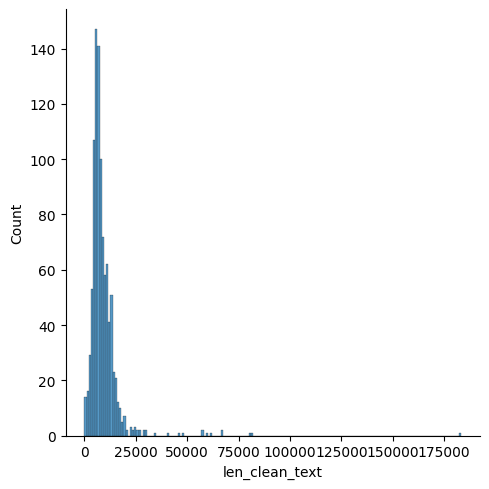

In [76]:
# #before cleaning - DONT RUN THIS
# import seaborn as sns
# df_news_final_project_sample = df_news_final_project_sample.dropna()
# df_news_final_project_sample = df_news_final_project_sample.drop_duplicates(subset=['cleaned_text'])
# df_news_final_project_sample['len_clean_text'] = df_news_final_project_sample['cleaned_text'].apply(lambda x: len(x))
# sns.displot(data=df_news_final_project_sample,x='len_clean_text')


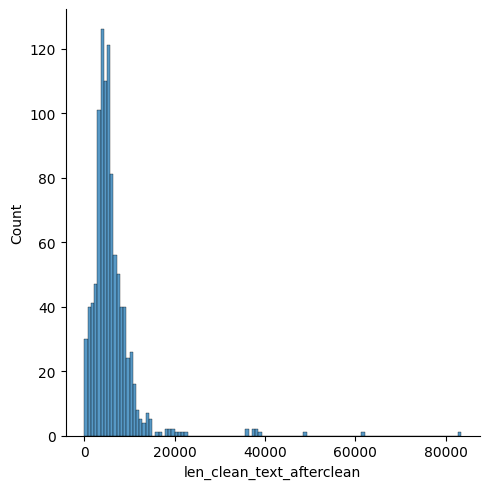

In [80]:
#after cleaning
import seaborn as sns
df_news_final_project_sample = df_news_final_project_sample.dropna()
df_news_final_project_sample = df_news_final_project_sample.drop_duplicates(subset=['cleaned_text'])
df_news_final_project_sample['len_clean_text_afterclean'] = df_news_final_project_sample['cleaned_text'].apply(lambda x: len(x))
sns.displot(data=df_news_final_project_sample,x='len_clean_text_afterclean')


In [100]:
news_df = df_news_final_project_sample

In [142]:
news_df.shape

(1000, 11)

In [144]:
news_df_1 = news_df.drop_duplicates(subset=['title'])
news_df_1.shape

(978, 11)

In [107]:
def tokenizer(string):
    words = nltk.tokenize.TweetTokenizer().tokenize(string)
    words = [word for word in words if len(word) > 1]
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words]
    words = [word for word in words if word not in stopwords]
    return words


In [108]:
news_df['cleaned_tokens'] = news_df['cleaned_text'].apply(tokenizer)


In [109]:
# Do preliminary topic modeling
dictionary_news = corpora.Dictionary(news_df['cleaned_tokens'])
corpus_news = [dictionary_news.doc2bow(doc) for doc in tqdm(news_df['cleaned_tokens'])]

print(f'Number of unique tokens: {len(dictionary_news)}')
print(f'Number of documents: {len(corpus_news)}')


100%|██████████| 1000/1000 [00:00<00:00, 1189.29it/s]

Number of unique tokens: 69876
Number of documents: 1000


In [127]:
tokenizer = nltk.tokenize.TweetTokenizer()

# This creates a list of all tokenized sentences
tokenized_sentences = news_df['cleaned_text'].apply(tokenizer.tokenize).tolist()

# This will flatten the list of lists into a single list
words = [word for sublist in tokenized_sentences for word in sublist]


In [140]:
bgs = nltk.bigrams(words)
targeted_bgs = ['machine','learning','ai','artificial','intelligence','natural','language','processing','chatgpt','data','science','python','r','c','analytics','ml','nlp','generative','legal','office','law','llm','large','language','model','management','business','finance','financial','industry','healthcare','production','service','manufacture','productivity','job','GenAI']
bgs = [b for b in bgs if (b[0] in targeted_bgs) or (b[1] in targeted_bgs)]
bigrams_freq = nltk.FreqDist(bgs)
bigrams_freq_df = pd.DataFrame(bigrams_freq.most_common(),columns=['Word', 'Frequency'])
bigrams_freq_df.head(n=50)


,Word,Frequency
0,"(artificial, intelligence)",3128
1,"(machine, learning)",943
2,"(intelligence, ai)",565
3,"(global, artificial)",446
4,"(data, science)",411
5,"(financial, services)",226
6,"(data, analytics)",165
7,"(generative, ai)",157
8,"(big, data)",155
9,"(ai, technology)",153


In [138]:
tgs = nltk.trigrams(words)
targeted_tgs = ['machine','learning','ai','artificial','intelligence','natural','language','processing','chatgpt','data','science','python','r','c','analytics','ml','nlp','generative','legal','office','law','llm','large','language','model','management','business','finance','financial','industry','healthcare','production','service','manufacture','productivity','job','GenAI']
tgs = [b for b in tgs if (b[0] in targeted_tgs) or (b[1] in targeted_tgs)]
trigrams_dist = nltk.FreqDist(tgs)
trigrams_dist_df = pd.DataFrame(trigrams_dist.most_common(),columns=['Word', 'Frequency'])
trigrams_dist_df.head(n=50)


,Word,Frequency
0,"(artificial, intelligence, ai)",544
1,"(global, artificial, intelligence)",434
2,"(artificial, intelligence, market)",115
3,"(artificial, intelligence, software)",102
4,"(ai, machine, learning)",95
5,"(artificial, intelligence, manufacturing)",95
6,"(automotive, artificial, intelligence)",92
7,"(matrix, ai, network)",90
8,"(natural, language, processing)",88
9,"(intelligence, ai, service)",88


In [141]:
# assuming 'words' is a list of tokenized words from your document
fourgrams = nltk.ngrams(words, 4)

targeted_fourgrams = [
    'machine', 'learning', 'ai', 'artificial', 'intelligence', 'natural', 
    'language', 'processing', 'chatgpt', 'data', 'science', 'python', 'r', 
    'c', 'analytics', 'ml', 'nlp', 'generative', 'legal', 'office', 'law', 
    'llm', 'large', 'language', 'model', 'management', 'business', 'finance', 
    'financial', 'industry', 'healthcare', 'production', 'service', 
    'manufacture', 'productivity', 'job', 'GenAI'
]

fourgrams = [
    b for b in fourgrams 
    if (b[0] in targeted_fourgrams) or (b[1] in targeted_fourgrams) 
    or (b[2] in targeted_fourgrams) or (b[3] in targeted_fourgrams)
]

fourgrams_dist = nltk.FreqDist(fourgrams)
fourgrams_dist_df = pd.DataFrame(fourgrams_dist.most_common(), columns=['Word', 'Frequency'])
fourgrams_dist_df.head(n=50)


,Word,Frequency
0,"(global, artificial, intelligence, ai)",102
1,"(artificial, intelligence, ai, service)",86
2,"(call, center, ai, market)",73
3,"(artificial, intelligence, energy, market)",71
4,"(intelligence, energy, market, market)",62
5,"(artificial, intelligencebased, security, market)",56
6,"(ai, computer, vision, market)",53
7,"(artificial, intelligence, software, market)",53
8,"(cyber, data, science, market)",52
9,"(automotive, artificial, intelligence, software)",47


In [121]:
#expand row line width
pd.set_option('display.max_colwidth', 1)

In [ ]:
# disregard irrelevant articles given task is to identify what industries and job lines are going to be most impacted by the AI over the next several years



In [ ]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df_news_final_project_sample['content_clean'] = df_news_final_project_sample['content_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 

# lemmatize
nltk.download('wordnet')